# Prosper Loans 2005-2008 - Characteristics of Borrowers and Loan Success
## by Andy Watson

## Background of the Dataset

I investigated loans from Prosper Marketplace (the country's first peer-to-peer lending marketplace), looking for variables that could serve as good predictors of a loan's future success or failure. 

To keep the project manageable, I restricted the search for predictor variables to borrower characteristics (ex: borrower's income, but not the loan's interest rate).

To ensure that I was dealing only with loans that should've been successfully completed by 2014 (when they stopped updating our dataset), I restricted my examination to loans originating between 2005 and 2008 (the loans in that time frame were 1 or 3 year loans, so at the latest all should've been paid off by 2011, according to the original terms of the loans).

As it happens, the timeframe from 2005 through 2008 also overlaps with the time prior to the SEC's ruling against Prosper, the subsequent changes in Prosper's business practices and the concommittant reduction in defaulted loans. That is to say, from what I've gathered (https://en.wikipedia.org/wiki/Prosper_Marketplace), it seems that during the time period I that reviewed, a high percentage of Prosper loans defaulted. 

It should also be remembered that the Financial Crisis of 2007-2008 happened during the time under review.

From all this, we can see that the data under review turned out to be a pretty special case.



## Measuring the Success of the Loans

How to measure a loan's success? 

My first idea was to reorganize the LoanStatus variable from one that recorded whether or not a loan was completed, defaulted, called off, or cancelled to one that simply declared a loan Successful (if it was completed by 2014) or Unsuccessful (if it was defaulted or called of by 2014) (from 2005 through 2008, only 5 loans were cancelled and I left them out of the evaluation). I named this new variable NewLoanStatus.

I soon began to worry that the Successful/Unsuccesful (ie: completed or not completed) metric did not contain enough information. For example, both a loan that recovered of all the principal plus 90% of the interest and a loan that recovered \\$0 would be classified "Unsuccessful", even though the former loan was clearly much more successful than the latter.

So I then created a variable called ROI (for "return on investment") that was created by subtracting the total money Prosper spent on the loan from the total money Prosper made on the loan.

I compared these two metrics against various possible predictor variables: StatedMonthlyIncome, IncomeRange, CreditGrade, CreditScoreRangeUpper, DebtToIncomeRatio, AmountDelinquent. These comparisons were made first on graphs and then mathematically, using correlation tests (Spearman and Pearson).

I found that CSRU had the best correlation scores. These scores were higher with NewLoanStatus than with ROI, which disappointed me, since ROI seems to be a more meaningful metric.



## Focus of the Slideshow

This slideshow features:

Graphs of the count distributions of my two metric variables (ROI and NewLoanStatus),

Graphs of ROI versus the CreditScoreRangeUpper (because ROI/CSRU had the highest correlation scores of any metric/predictor pairing),

And a summary of the correlation test results. 


## Dataset Overview

The file contains data on 113,937 loans (rows) with 81 variables (columns).

Variables include loan amount, interest rate, information about borrower's financial history, and current loan status.

The data was collected from 2005 through 2014.

After I removed all the loans that originated after the end of 2008, I was left with 29056 loans.



In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
loan = pd.read_csv('prosperLoanData.csv')

In [3]:
# make a copy of the data frame
loans_to_2008 = loan.copy()

# change the ListingCreationDate variable to datetime format
loans_to_2008['ListingCreationDate'] = pd.to_datetime(loans_to_2008['ListingCreationDate']) 

In [4]:
# choose the loans made from 2005 through 2008
loans_to_2008 = (loans_to_2008[loans_to_2008['ListingCreationDate'].dt.year <= 2008])
# the dataframe needs a continuous index
loans_to_2008.reset_index(drop=True, inplace=True)

In [5]:
# creating successful and unsuccessful columns

# create a dictionary so you can map the values onto the new category names
dict_map = dict(zip(['Completed', 'Chargedoff', 'Defaulted', 'Cancelled'], ['Successful', 'Unsuccessful', 'Unsuccessful', 'Cancelled']))
# create a NewLoanStatus variable by mapping the dictionary onto the LoanStatus dictionary
loans_to_2008['NewLoanStatus'] = loans_to_2008['LoanStatus'].map(dict_map)

In [6]:
# creating the ROI variable by calculating the loans' return on investments
loans_to_2008['ROI'] = (loans_to_2008['LP_CustomerPayments'] - loans_to_2008['LoanOriginalAmount'] - loans_to_2008['LP_ServiceFees'] - loans_to_2008['LP_CollectionFees'] + loans_to_2008['LP_NonPrincipalRecoverypayments'])/loans_to_2008['LoanOriginalAmount'] 


In [7]:
# as an exercise, I'll turn these ordinal variables into categories computationally.

# convert CreditGrade and IncomeRange into ordered categorical types
ordinal_var_dict = {'CreditGrade': ['AA', 'A', 'B', 'C', 'D', 'E', 'HR','NC'],
                    'IncomeRange': ['$0', '$1-24,999', '$25,000-49,999', '$50,000-74,999', '$75,000-99,999', '$100,000+','Not employed', 'Not displayed']}

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True, categories = ordinal_var_dict[var])
    loans_to_2008[var] = loans_to_2008[var].astype(ordered_var)

In [8]:
# creating the typical_incomes dataframe and Successful & Unsuccessful subsets
# (for the final graph)

# create typical_incomes df
typical_incomes = (loans_to_2008[(loans_to_2008['StatedMonthlyIncome'] <= 60000) & (loans_to_2008['StatedMonthlyIncome'] >= 300)]).copy()
typical_incomes.reset_index(drop=True, inplace=True)

# create successful and unsuccessful dataframes
typ_succ = typical_incomes[typical_incomes['NewLoanStatus']=='Successful'].copy()
typ_unsucc = typical_incomes[typical_incomes['NewLoanStatus']=='Unsuccessful'].copy()

# the below are used to draw lines depicting each variable's mean value on the graph
avg_smi_succ = typ_succ.StatedMonthlyIncome.mean()
avg_roi_succ = typ_succ.ROI.mean()
avg_smi_unsu = typ_unsucc.StatedMonthlyIncome.mean()
avg_roi_unsu = typ_unsucc.ROI.mean()

## Distribution Counts for NewLoanStatus 

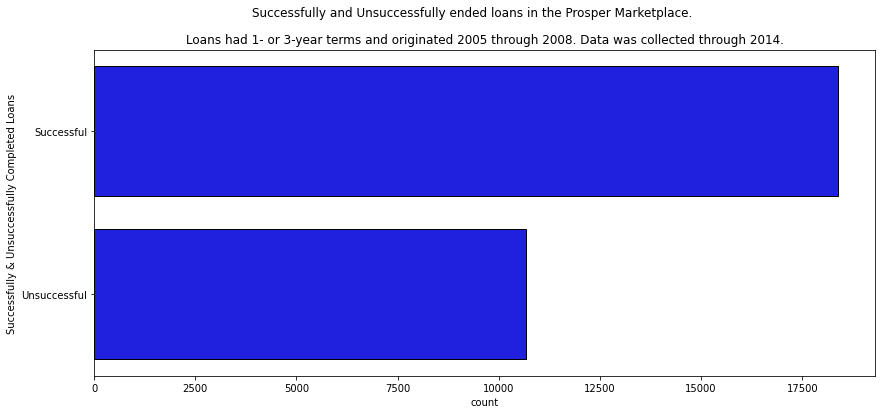

In [9]:
# hide the code so it doesn't interfere with the size of the slide
{
    "tags": [
        "to_remove"
    ],
    "slideshow": {
        "slide_type": "fragment"
    }
}

# countplot of successfully completed versus uncompleted loans
# remove the Cancelled loans (I am not sure if they count as Successful or Unsuccessful, and there are only 5 of them anyway)
no_cancelled = loans_to_2008[loans_to_2008['NewLoanStatus']!='Cancelled'].copy()
plt.figure(figsize=[14, 6])
sb.countplot(data=no_cancelled, y='NewLoanStatus', color='blue', edgecolor='black')
plt.suptitle('Successfully and Unsuccessfully ended loans in the Prosper Marketplace.')
plt.ylabel('Successfully & Unsuccessfully Completed Loans')
plt.title('Loans had 1- or 3-year terms and originated 2005 through 2008. Data was collected through 2014.');


> If we declare all loans that originated between 2005 and 2008 and that were completed by 2014 "Successful", and the rest of those loans (either Defaulted or Chargedoff, and ignoring the 5 Cancelled loans) "Unsuccessful, about 63% of the loans were successful.

## Distribution Counts for ROI

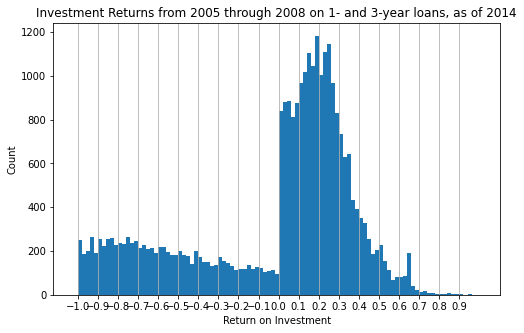

In [10]:
# hide the code so it doesn't interfere with the size of the slide
{
    "tags": [
        "to_remove"
    ],
    "slideshow": {
        "slide_type": "fragment"
    }
}

# histogram of ROI variable
binsize = .02
ticksize = .1
bins = np.arange(-1-binsize, 1+binsize, binsize)
ticks = np.arange(-1, 1, ticksize)

plt.figure(figsize=[8, 5])
plt.hist(data = loans_to_2008, x = 'ROI', bins=bins)
plt.xlabel('Return on Investment')
plt.ylabel('Count')
plt.title('Investment Returns from 2005 through 2008 on 1- and 3-year loans, as of 2014')
plt.xticks(ticks)
plt.grid(axis='x')
plt.show();

> The bulk of the loans seem to have either about a 10%, 20%,or 30% return (the 0-10% range contains over 4000 loans, the other two ranges each contain over 5000 loans). Fewer, but a still substantial amount of loans have a 40% return (around 3000 loans). 

> About 1000 loans had a 50% return, and then the numbers drop off smoothly for 60% and 70% returns. ROIs higher than that are very rare in the data set.

> On the negative side, the -100%, -90%, and -80% ROI columns each contain about 1000 loans, and the counts drop off gradually from there to 0, where there appear to be about 500 loans where the lender broke even.

> Below I break the ROI count into 10% intervals mathematically.

### ROI counts broken into 10% intervals

In [11]:
# hide the code so it doesn't interfere with the size of the slide
{
    "tags": [
        "to_remove"
    ],
    "slideshow": {
        "slide_type": "fragment"
    }
}

# create bins for the ROI values
binsize=.1
bins = np.arange(-1-binsize, 1+binsize, binsize)

roi_bins = pd.cut(loans_to_2008['ROI'], bins)

# group loans by the ROI bins
loans_to_2008.groupby(roi_bins)['ROI'].count()

ROI
(-1.1, -1.0]         244
(-1.0, -0.9]         853
(-0.9, -0.8]        1225
(-0.8, -0.7]        1208
(-0.7, -0.6]        1052
(-0.6, -0.5]         994
(-0.5, -0.4]         905
(-0.4, -0.3]         747
(-0.3, -0.2]         711
(-0.2, -0.1]         612
(-0.1, 8.88e-16]     539
(8.88e-16, 0.1]     4296
(0.1, 0.2]          5317
(0.2, 0.3]          5051
(0.3, 0.4]          2829
(0.4, 0.5]          1324
(0.5, 0.6]           645
(0.6, 0.7]           421
(0.7, 0.8]            51
(0.8, 0.9]            20
(0.9, 1.0]             6
Name: ROI, dtype: int64

## CreditScoreRangeUpper versus ROI (Scatterplot)


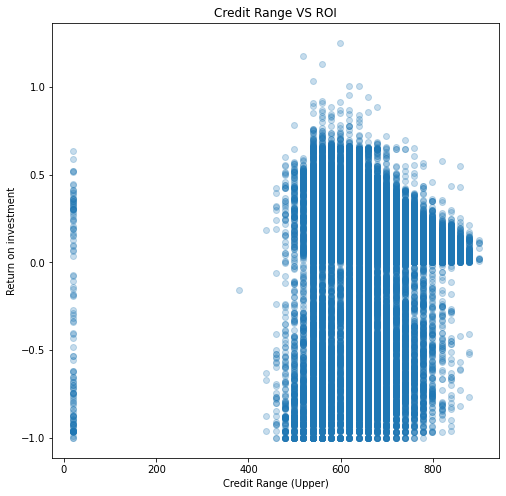

In [12]:
# hide the code so it doesn't interfere with the size of the slide
{
    "tags": [
        "to_remove"
    ],
    "slideshow": {
        "slide_type": "fragment"
    }
}

# a scatterplot comparing the CSRU and ROI variables
plt.figure(figsize = [8, 8])
plt.scatter(data = loans_to_2008, x = 'CreditScoreRangeUpper', y = 'ROI', alpha=1/4)
plt.xlabel('Credit Range (Upper)')
plt.ylabel('Return on investment')
plt.title('Credit Range VS ROI')
plt.show();

> From this graph, it looks like during this time period, CSRU 550-650 was was the credit range with the highest payoffs. This is pobably related to the relatively high interest rates charged to people with those (not spectacularly good) credit ratings. 

> (I don't know why there don't seem to be any loans for CSRU scores below 400, excepting that line of loans to people with CSRUs of about zero -- which I also can't explain.)


## CreditScoreRangeUpper versus ROI (Barplot)

> The above scatterplot with alpha-shading gives a sense of the distribution of ROIs at the various credit ranges, but it doesn't clearly demonstrate the average ROIs for loans from each credit range. We'll draw a barplot for that.

Text(0.5, 1.0, 'Credit Range VS ROI')

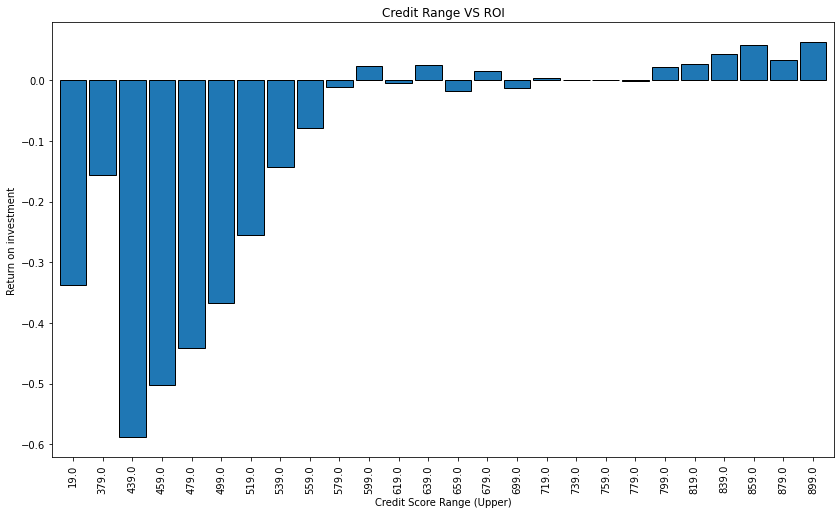

In [13]:
# hide the code so it doesn't interfere with the size of the slide
{
    "tags": [
        "to_remove"
    ],
    "slideshow": {
        "slide_type": "fragment"
    }
}

# bar plot
loans_to_2008[['CreditScoreRangeUpper', 'ROI']].groupby('CreditScoreRangeUpper').ROI.mean().plot.bar(edgecolor='black', figsize=[14,8], width=.9);
plt.xlabel('Credit Score Range (Upper)')
plt.ylabel('Return on investment')
plt.title('Credit Range VS ROI')

> The middle Credit Ranges show mixed results. The lower Credit Score Ranges resulted in uniformly negative average ROIs. Only up around upper credit ranges of about CSRU 800-900 does Prosper start to turn a solid profit. 

> There is a gradual downward trend in the negative range from about CSRU 599 / ROI -.1 through CSRU 439 / ROI -.58 

> There is an upward trend from about CSRU 800 / ROI .05 through about CSRU 900 / ROI .4 (with a dip down at CSRU 879 / ROI .2)

> In hindsight, During this time period, loaning only to people with CSRUs over 719 would've been a very safe bet; and loaning only to people with CSRUs below 579 would've been a terrible bet, resulting in huge losses.

## Summary of Correlation Coefficient scores for the full loans_to_2008 dataset.

> ## Interpreting Correlation Coefficient Scores:

> Generally, scores above |.5| are considered strong; moderate scores start at |.3| and weak ones at |.1|; scores below |.1| indicated correlations that are either very weak or nonexistent.

> I performed Spearman scores on all tests and Pearson on most. In the below synopsis, I record only the higher of the two tests. 

#### Primary-Metrics/Predictor-Variables:

NewLoanStatus/CreditGrade .20 | NLS/AmountDelinquent -.15 | NLS/CredScoreRangeUpper .27 | NLS/CreditGrade .2

With ROI, the best predictor/metric scores were ROI/CG .14 and ROI/CSRU .12

All other prector/metric scores were below |.1| 

#### Other Correlation Coefficient Scores:

The two primary metrics (ROI & NewLoanStatus): .72 

StatedMonthlyIncome and CreditScoreRange: .24 | CreditGrade and CreditScoreRange: .99 

> typical_incomes dataframe: When I removed incomes outside of the main shape of the StatedMonthlyIncome versus ROI graph, the scores increased a little: ROI/CSRU .14 | SMI/CSRU .27 

## Discussion of Correlation Coefficient scores for the full loans_to_2008 dataset.

> It was encouraging to see the strong correlation between my two success-metrics: ROI/NLS .72 (If the metrics were to have a chance at being credible, they should've been highly correlated -- and they were.)

I was surprised that the predictor variables correlated better with the simple Successful/Unsuccessful metric (NewLoanScore) than with ROI. I'd thought ROI's more exact description of the loan outcomes would translate into a more exact fit to the predictor variables. But in hindsight, it is easier to predict whether a loan was completed or not than how much profit a loan will return.

> It is disappointing that none of my predictor/primary pairings received even moderate correlation scores (NLS/CSRU was the highest, with .27). Perhaps this is due to the rough times both Prosper and the global economy went through during the time period I investigated.

I was surprised that SMI and CSRU weren't more closely related: SMI/CSRU .24 (a fairly weak correlation -- moderate correlations start at |.3|). I guess one's monthly income is not an overwhelmingly important factor in determining one's credit rating.

> As I assumed the Credit Grades are probably just a less exact version of the Credit Score Ratings, I thought CG/CSRU would result in a high very high correlation score, but .99 is a very very very high score. 

### Conclusions

> We didn't discover any great predictors for our loan-success metrics. Perhaps this is due to the poor performance of Prosper loans during the studied interval. And/Or perhaps there is some flaw in my analysis. And/Or (given my lack of knowledge in this field I must still entertain the possibilty that) perhaps the correlations are just generally not that strong and loan success is generally difficult to predict.

> The high correlation scores between the two loan-success metrics (ROI/NLS scored .72) was more encouraging, as was the fact that the relationships that one would've thought should be positive were positive, and the scores that one would've thought should be negative (ie: ROI/DebtToIncomeRatio & ROI/AmountDelinquent) were negative. These findings make me feel that the analysis was at least on the right track.

In [ ]:
!jupyter nbconvert prosper_slide_deck.ipynb --to slides --post serve --no-input --no-prompt

[NbConvertApp] Converting notebook prosper_slide_deck.ipynb to slides
[NbConvertApp] Writing 719236 bytes to prosper_slide_deck.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Serving your slides at http://127.0.0.1:8000/prosper_slide_deck.slides.html
Use Control-C to stop this server
